<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# Object Detection

Today you are a machine learning engineer on the Spatial Perception Team (SPT) at Apple. The goal is to levarage an existing object detector model to automatically detect dogs, an application of **transfer learning**. 

The idea is that you have access to a model that you or one of your colleagues has already trained on a large and diverse set of images, but the model is not very specific for your task (dog detection). We'll do transfer learning by fine-tuning this existing model on a small dataset of dog images. 

*This is only a small part of the end product -- Visual Look Up feature released in iOS 15 -- snap a picture, identify if an object belonging to five categories (art, landmarks, nature, books, and pets) exists, if yes, highlight with a object symbol, and further identify, e.g., the species of a plant. Examples are shown below ([picture credits](https://www.iphonetricks.org/how-to-visual-look-up-photos-on-iphone/))*

<div>
<img src="https://149493502.v2.pressablecdn.com/wp-content/uploads/2021/07/visual-look-up-categories.jpg" width="500"/>
</div>

## Learning Objectives

At the end of this session, you will be able to

- understand [few-shot learning (FSL)](https://neptune.ai/blog/understanding-few-shot-learning-in-computer-vision)
- understand the mechanics of using pretrained model and fine tune a pretrained model 
- calculate metrics and evaluate detection model

## Task 1: Setup

1. We will run this notebook via Google Colab to take advantage of its free GPU computing power and avoid installation pain.
  
    It is however not hassle-free, three steps to ensure no errors running this notebook for the time being (this looks familiar to you if you have run the demo notebook):
    - step 1. `Runtime` > `Disconnect and delete runtime`
    - step 2. make sure the runtime is **GPU**: `Runtime` > `Change runtime type`
    - step 3. run the following cell to install `tensorflow` 2.8, as well as the compatible GPU-accelerated library; solution is based on this [issue](https://github.com/tensorflow/models/issues/10558). Depending on the internet connection, it could take a few minutes to finish.

In [2]:
!pip install -U -q tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     / 668.3 MB 400 kB/s
     |████████████████████████████████| 462 kB 32.7 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 47 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (65.5 MB/s)
(Reading database ... 155639 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155617 files and directories currently installed.)
Preparing to unpac

Use the NVIDIA System Management Interface to check the GPU device you are on. 

In [3]:
!nvidia-smi 

Fri Jul  1 13:42:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

1. Mount the drive to ensure access to where you store the images on Google Drive. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1. Clone the [tensorflow models repository](https://github.com/tensorflow/models) so we can make use of a model that has already been trained.

In [5]:
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3403, done.
remote: Counting objects: 100% (3403/3403), done.
remote: Compressing objects: 100% (2830/2830), done.
remote: Total 3403 (delta 896), reused 1411 (delta 516), pack-reused 0
Receiving objects: 100% (3403/3403), 34.96 MiB | 33.64 MiB/s, done.
Resolving deltas: 100% (896/896), done.


1. Install dependencies of the pretrained models. This can take a few minutes.

In [6]:
%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install -q -U .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.




  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.13 requires dill>=0.3.5.1, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.1.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.

## Task 2: Load and examine data

1. Make sure to upload the folder `dog_dataset` containing all images and annotation files to your google drive `/content/drive/My Drive/fourthbrain/dog_dataset`. 

    Retrieve a list containing the names of the training images in the directory given by `train_image_dir`. Use `os.listdir` and store the results to `image_names`; e.g., 
    ```python
    image_names[0] # dog_004.jpg
    ```

In [7]:
import os

dog_dataset_path = '/content/drive/My Drive/fourthbrain/dog_dataset' # Replace with actual path
train_image_dir = os.path.join(dog_dataset_path, 'train/images')
image_names = os.listdir(train_image_dir) # YOUR CODE HERE
print(image_names)

['dog_008.jpg', 'dog_001.jpg', 'dog_002.jpg', 'dog_010.jpg', 'dog_007.jpg', 'dog_005.jpg', 'dog_006.jpg', 'dog_003.jpg', 'dog_009.jpg', 'dog_004.jpg']


In [8]:
assert len(image_names) == 10

1. Function `load_image_into_numpy_array()` below is provided to load the an image given `path`.

    Examine the code and use it to read all the training images and store them in list `train_images_np`.

In [9]:
import tensorflow as tf
from PIL import Image
from six import BytesIO
import numpy as np

def load_image_into_numpy_array(path):
    """
    Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    im_width, im_height = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [10]:
train_images_np = []
# YOUR CODE HERE
for image in image_names:
  image_path = os.path.join(dog_dataset_path, "train/images", image)
  train_images_np.append(load_image_into_numpy_array(image_path))


In [11]:
assert len(train_images_np) == 10 

In [12]:
assert train_images_np[0].shape == (480, 640, 3)

1. What is the shape of each image (width, height and number of color channels)? 

In [13]:
# YOUR CODE HERE
print("Shape of each image in training set: ")
for image in train_images_np:
  print(image.shape)

Shape of each image in training set: 
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)


1. Use the following code to draw all 10 images. 

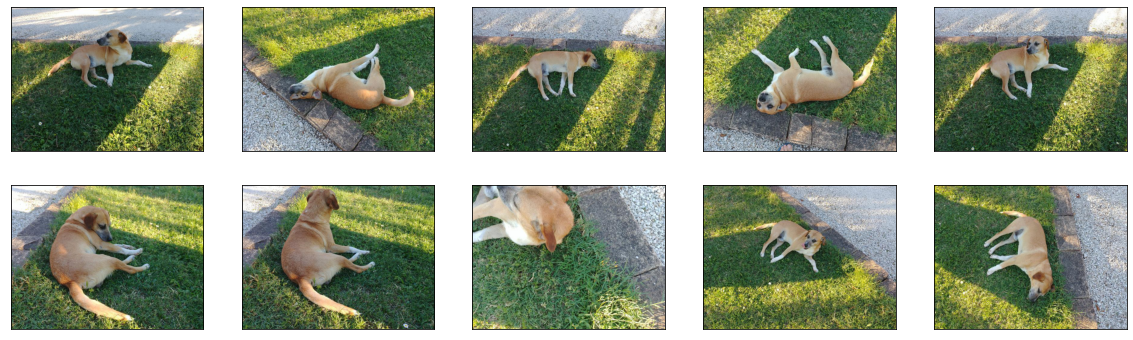

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
for idx, train_image_np in enumerate(train_images_np):
    ax = plt.subplot(2, len(train_images_np) / 2, idx + 1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(train_image_np)
    

1. Recall our task is to detect where the dog is in the image. 

    The object detection model we'll use spits out bounding boxes where it thinks there **might** be an object. For each bounding box, it also makes a prediction of which class the object is from, and there is an associated "score", or confidence, of this prediction. 

    The format for specifying bounding boxes of our training data and the model outputs are [$y_{\min}$, $x_{\min}$, $y_{\max}$, $x_{\max}$], where $y$ is the vertical position and $x$ is the horizontal position. For example, a bounding box of [0.1, 0.15, 0.8, 0.9] means one whose lower left corner is at position (0.1, 0.15) and whose upper right corner is at (0.8, 0.9).

    These values, ranging between 0 and 1, are **agnostic** to the size of the image, if you wanted to convert them to pixels you would multiply by the width or height of the image (in pixels). 

    We will use function `visualize_boxes_and_labels_on_image_array` in the object detection visualization utilities to display the bounding boxes overlaid on an image.

    First, though, let's read annotations (including the ground-truth bounding boxes) for these training images.

1. Use function `read_content()` given below to read in all the annotations and save them in a list `gt_boxes`.

In [15]:
import xml.etree.ElementTree as ET
from typing import Tuple

def read_content(xml_file: str, h: int, w: int) -> Tuple[str, list]:
    """ parse metadata/annotation 
    
    Args:
        xml_file (str): path to a xml file
        h (int): height
        w (int): width
        
    Return:
        Tuple[str, list]: 
    """
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):
        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text) / h
        ymax = int(boxes.find("bndbox/ymax").text) / h
        xmin = int(boxes.find("bndbox/xmin").text) / w
        xmax = int(boxes.find("bndbox/xmax").text) / w

        list_with_single_boxes = [ymin, xmin, ymax, xmax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [128]:
train_ann_dir = os.path.join(dog_dataset_path, 'train/annotations')
gt_boxes = []
# YOUR CODE HERE
anotation_names = os.listdir(train_ann_dir)
h = train_images_np[0].shape[0]
w = train_images_np[0].shape[1]
for anotation_file in anotation_names:
  path_anotation_file = os.path.join(train_ann_dir, anotation_file)
  filename, list_with_all_boxes = read_content(xml_file=path_anotation_file, h=h, w=w)
  gt_boxes.append(list_with_all_boxes)


In [129]:
assert len(gt_boxes) == len(train_images_np)

1. Inspect and run the following code to create the target tensors for our model to use in training.

In [130]:
dog_class_id = 1
num_classes = 1

category_index = {dog_class_id: {'id': dog_class_id, 'name': 'dog'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []

for train_image_np, gt_box_np in zip(train_images_np, gt_boxes):
    gt_box_np = np.array(gt_box_np)
    train_image_tensors.append(
        tf.expand_dims(
            tf.convert_to_tensor(train_image_np, dtype=tf.float32),
            axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(
        tf.one_hot(zero_indexed_groundtruth_classes, num_classes))

1. Call function `visualize_boxes_and_labels_on_image_array()` to plot these bounding boxes on their respective images. Look at the images which show the dogs corrected identified in each image.

Bounding box for image 0:  [[0.30833333333333335, 0.18125, 0.6520833333333333, 0.66875]]
Bounding box for image 1:  [[0.2520833333333333, 0.2359375, 0.7208333333333333, 0.9015625]]
Bounding box for image 2:  [[0.20416666666666666, 0.246875, 0.75, 0.8859375]]
Bounding box for image 3:  [[0.24791666666666667, 0.25625, 0.6083333333333333, 0.63125]]
Bounding box for image 4:  [[0.1875, 0.253125, 0.8166666666666667, 0.6171875]]


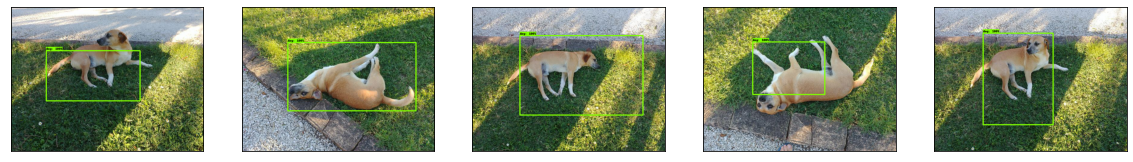

In [131]:
from object_detection.utils import visualization_utils as viz_utils

dummy_scores = np.array([1.0], dtype=np.float32)
plt.figure(figsize=(20, 3))
gt_boxes_1 = np.asarray(gt_boxes)
for idx in range(5):
    ax = plt.subplot(1, 5, idx + 1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    temp_img_copy = np.copy(train_images_np[idx])
    viz_utils.visualize_boxes_and_labels_on_image_array(
        temp_img_copy,
        gt_boxes_1[idx],
        np.ones(shape=[gt_boxes_1[idx].shape[0]], dtype=np.int32),
        dummy_scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.0)
    plt.imshow(temp_img_copy)
    print(f'Bounding box for image {idx}: ', gt_boxes[idx])


1. Follow the similar process to load test images and save them in list `test_images_np`, except that each image is expected in `NHWC` format with `N` set to be 1. Hint: use `np.expand_dims`. 

    Check [Table 1. Parameters defining a convolution](https://docs.nvidia.com/deeplearning/performance/dl-performance-convolutional/index.html#convo-intro)  for what each letter means in format such as `NHWC`. 

In [132]:
%%time
test_images_np = []
test_image_dir = os.path.join(dog_dataset_path, 'test/images')
t_image_names = os.listdir(test_image_dir)

# YOUR CODE HERE
for image in t_image_names:
  image_path = os.path.join(test_image_dir, image)
  test_images_np.append(np.expand_dims(load_image_into_numpy_array(image_path), axis=0))
#test_images_np = np.asarray(test_images_np)

CPU times: user 8.04 s, sys: 606 ms, total: 8.65 s
Wall time: 8.68 s


In [133]:
assert len(test_images_np) == 40

In [134]:
assert test_images_np[0].shape == (1, 480, 640, 3)

1. Follow the same process as above to load in the bounding box annotations for the test images. Save them in `t_gt_boxes`.

In [ ]:
t_gt_boxes = []
test_ann_dir = os.path.join(dog_dataset_path, 'test/annotations/xmls')
t_anotation_names = os.listdir(test_ann_dir)

# YOUR CODE HERE

for image, anotation_file in zip(test_images_np, t_anotation_names):
  h = image.shape[1]
  w = image.shape[2]
  path_anotation_file = os.path.join(test_ann_dir, anotation_file)
  filename, list_with_all_boxes = read_content(xml_file=path_anotation_file, h=h, w=w)
  t_gt_boxes.append(list_with_all_boxes[0])


In [ ]:
assert len(test_images_np) == len(t_gt_boxes) == 40

## Task 3: Load and run object detection model

1. Download the checkpoint and put it into `models/research/object_detection/test_data/`.

    This model is an [SSD (single shot multibox detector)](https://arxiv.org/pdf/1512.02325.pdf) object detetion with Resnet50 backbone with feature pyramid network. You can choose other models, such as YOLO, feasterRCNN, etc. 
    
    Note. For simplicity, a number of things in this notebook is harcoded for the specific RetinaNet architecture at hand, including assuming that the image size will always be 640x640. 
    
    Another note. TensorFlow Hub is now the repository of trained machine learning models ([TensorFlow Hub Object Detection Colab tutorial](https://www.tensorflow.org/hub/tutorials/tf2_object_detection)), however it seems that tensorflow hub models are not fine-tunable; see [issue](https://github.com/tensorflow/hub/issues/678).

In [25]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-07-01 13:45:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.62.128, 2607:f8b0:4004:815::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.62.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   326MB/s    in 0.7s    

2022-07-01 13:45:25 (326 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



1. Run the code below to load the pretrained model.

    One reason it is fairly complex is that the pretrained model requires backward compatibility with TensorFlow 1.0 and because there is some added complexity for managing all the different pretrained models in this particular repository. For some documentation on the simpler and more clean semantics of saving and loading model checkpoints in TensorFlow 2.0 see [this documentation](https://www.tensorflow.org/tutorials/keras/save_and_load?authuser=2)

In [ ]:
from object_detection.utils import config_util
from object_detection.builders import model_builder
import tensorflow as tf
tf.keras.backend.clear_session()

num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)


1. Use the following code to make some predictions *before* fine-tuning. The model by default will generate 100 possible objects, each with associated scores and predicted classes.

    We utilize the `detect()` function, which wraps the preprocessing, prediction, and postprocessing step with the `tf.function` dectorator so that this computation will enjoy faster performance (see [this tutorial](https://www.tensorflow.org/guide/function) for more context).

In [140]:
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
      input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.

    Returns:
      A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
        and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)
    

In [141]:
pre_ft_bb_preds = []
pre_ft_scores_preds = []
pre_ft_classes_preds = []
label_id_offset = 1
plt.figure(figsize=(20, 20))
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    pre_ft_bb_preds.append(detections['detection_boxes'][0].numpy())
    pre_ft_scores_preds.append(detections['detection_scores'][0].numpy())
    pre_ft_classes_preds.append(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)
    if i < 5:
        ax = plt.subplot(3, 2, i + 1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        temp_img_copy = np.copy(test_images_np[i][0])
        viz_utils.visualize_boxes_and_labels_on_image_array(
            temp_img_copy,
            pre_ft_bb_preds[-1],
            pre_ft_classes_preds[-1],
            pre_ft_scores_preds[-1],
            category_index,
            use_normalized_coordinates=True,
            min_score_thresh=0.0
        )
        plt.imshow(temp_img_copy)

Output hidden; open in https://colab.research.google.com to view.

1. You can see that it makes some bad predictions (though the correct prediction is one of the possibilities). Let's just display its most confident prediction.

In [142]:
plt.figure(figsize=(20, 20))
for i in range(5):
    ax = plt.subplot(3, 2, i + 1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    most_confident_bb = np.argmax(pre_ft_scores_preds[i])
    temp_img_copy = np.copy(test_images_np[i][0])
    viz_utils.visualize_boxes_and_labels_on_image_array(
        temp_img_copy,
        pre_ft_bb_preds[i][most_confident_bb][None, :],
        np.array([pre_ft_classes_preds[i][most_confident_bb]]),
        np.array([pre_ft_scores_preds[i][most_confident_bb]]),
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.0
    )
    plt.imshow(temp_img_copy)

Output hidden; open in https://colab.research.google.com to view.

## Task 4: Implement Computation of Intersection Over Union metric

1. The [Intersection over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is one way to measure how *good* a bounding box prediction is.

   Complete the `bounding_box_iou()` function below. You will need to complete these steps in the code:
   
   - Determine the coodinates of the intersection rectangle.
   - Compute the area of the intersection rectangle.
   - Compute the area of both the prediction and ground-truth rectangles.
   - Compute and return the intersection over union by taking the intersection area and dividing it by the sum of the prediction and ground-truth areas minus the intersection area.

In [143]:
def bounding_box_iou(boxA:list, boxB:list) -> float:
    """
    Computes the Intersection over Union for two bounding boxes

    Args:
        boxA (ymin, xmin, ymax, xmax)
        boxB (ymin, xmin, ymax, xmax)
    
    Return: intersection Over Union metric given two boxes cordinates
    """
    # YOUR CODE HERE
    #find intersection corner
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])

    # boxes area
    boxA_area = (boxA[3] - boxA[1]) * (boxA[2] - boxA[0])
    boxB_area = (boxB[3] - boxB[1]) * (boxB[2] - boxB[0])
  
    # Interseciton
    if (xA <= xB) and (yB >= yA):
      interArea = (xA - xB) * (yA - yB)
      iou = interArea / float(boxA_area + boxB_area - interArea)
    else:
      iou = 0

    return iou


In [144]:
assert bounding_box_iou([0,0,1,1], [0,0,1,1]) == 1
assert bounding_box_iou([0,0,1,1], [1,1,2,2]) == 0

2. Use the `compute_best_iou_and_score()` function to find the best IoU and scores of the test images.

    Remember the test images are stored in `t_gt_boxes`, the predicted bounding boxes are stored in `pre_ft_bb_preds` and the prediction scores per bounding box are stored in `pre_ft_scores_preds`.

In [145]:
def compute_best_iou_and_score(gt_bounding_box, predicted_bounding_boxes, prediction_scores_per_bb):
    """
    compute the best IoU and scores
    """
    indv_ious = []
    for bbox_idx in range(len(predicted_bounding_boxes)):
        indv_ious.append(bounding_box_iou(gt_bounding_box, predicted_bounding_boxes[bbox_idx]))
        #print(np.max(indv_ious))
    if len(indv_ious) == 0:
        return 0, 0
    best_bounding_box = np.argmax(indv_ious)
    return indv_ious[best_bounding_box], prediction_scores_per_bb[best_bounding_box]


In [146]:
bounding_box_iou(t_gt_boxes[1], pre_ft_bb_preds[1][0])

0.012603222466452601

In [147]:
ious = []
scores = []
# YOUR CODE HERE
for i in range(len(t_gt_boxes)):
  ious_, scores_ = compute_best_iou_and_score(t_gt_boxes[i], pre_ft_bb_preds[i], pre_ft_scores_preds[i])
  #print(ious_)
  ious.append(ious_)
  scores.append(scores_)

print('The mean IoU on the test images is: ', np.mean(ious))
print('The associated scores are: ', np.mean(scores))


The mean IoU on the test images is:  0.2468607405448881
The associated scores are:  0.029048497


In [149]:
assert np.isclose(np.mean(ious), .25, atol=5e-2) # Expect the mean IoU to be in the neighborhood of .25
assert np.isclose(np.mean(scores), .03, atol=1e-2)

## Task 5: Fine-tune the model

1. The variables that we can train are located in the `.trainable_variables` attribute of the model `detection_model`. How many variables are there?

In [42]:
# YOUR CODE HERE
print(f"The number of trainable variables in detection_model: {len(detection_model.trainable_variables)}")

The number of trainable variables in detection_model: 269


1. Print the names of all the trainable variables.

In [43]:
# YOUR CODE HERE
trainable_names = {}
for i in range(len(detection_model.trainable_variables)):
  trainable_names[i] = detection_model.trainable_weights[0].name
trainable_names

{0: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 1: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 2: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 3: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 4: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 5: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 6: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 7: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 8: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',
 9: 'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0',


We're going to fine tune the `WeightSharedConvolutionalBoxPredictor` layer only. Don't worry about why specifically this layer for the purposes of this tutorial. When you fine tune your own models, picking which parts of it to fine tune are a combination of the inductive bias you impose, and the result of hyperparameter optimization.

1. Complete the `get_model_train_step_function()` function.

    * Use the model's `.predict()` method to generate predictions and save as `prediction_dict`.
    * Use the model's `.loss()` method and save as `losses_dict`.
    * Make `total_loss` equal to the sum of `localization_loss` and `classification_loss` from the losses dictionary.

In [44]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors, groundtruth_boxes_list, groundtruth_classes_list):
        """A single training iteration.
        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth classes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes) # YOUR CODE HERE
            losses_dict = model.loss(prediction_dict, shapes) # YOUR CODE HERE
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']#  YOUR CODE HERE
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn


1. Set the tuning parameters. We give reasonable values, but feel free to adjust them and see how it affects the convergence of the model.

In [161]:
batch_size = 10
learning_rate = 0.02
num_batches = 100

1. Complete the following code by completing the `optimizer` and `train_step_fn`.

    * Instantiate an SGD optimizer using the learning rate, and a momentum of 0.9 and save it as `optimizer`.
    * Call the `get_model_train_step_function()` function to create `train_step_fn`.

In [162]:
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9) # YOUR CODE HERE
train_step_fn = get_model_train_step_function(detection_model, optimizer, to_fine_tune) # YOUR CODE HERE

1. Run the following code to do the fine-tuning.

In [163]:
import random

for idx in range(num_batches):
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]
    
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')


batch 0 of 100, loss=0.04350464
batch 10 of 100, loss=0.038938325
batch 20 of 100, loss=0.032170083
batch 30 of 100, loss=0.026710134
batch 40 of 100, loss=0.02280007
batch 50 of 100, loss=0.019986548
batch 60 of 100, loss=0.01787641
batch 70 of 100, loss=0.016224623
batch 80 of 100, loss=0.014885741
batch 90 of 100, loss=0.013771267
Done fine-tuning!


1. Now look at the bounding boxes for our fine-tuned model.

In [164]:
post_ft_bb_preds = []
post_ft_scores_preds = []
post_ft_classes_preds = []
plt.figure(figsize=(20, 20))

for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    post_ft_bb_preds.append(detections['detection_boxes'][0].numpy())
    post_ft_scores_preds.append(detections['detection_scores'][0].numpy())
    post_ft_classes_preds.append(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)
    if i < 5:
        ax = plt.subplot(3, 2, i + 1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        temp_img_copy = np.copy(test_images_np[i][0])
        most_confident_bb = np.argmax(post_ft_scores_preds[i])
        viz_utils.visualize_boxes_and_labels_on_image_array(
            temp_img_copy,
            post_ft_bb_preds[i][most_confident_bb][None, :],
            np.array([post_ft_classes_preds[i][most_confident_bb]]),
            np.array([post_ft_scores_preds[i][most_confident_bb]]),
            category_index,
            use_normalized_coordinates=True,
            min_score_thresh=0.0
        )
        plt.imshow(temp_img_copy)

Output hidden; open in https://colab.research.google.com to view.

1. Compute the mean IoU and scores for the fine_tuned model following the same steps as in task 4. The performance should be much better than the original model.

In [165]:
ious = []
scores = []
# YOUR CODE HERE
for i in range(len(t_gt_boxes)):
  ious_, scores_ = compute_best_iou_and_score(t_gt_boxes[i], post_ft_bb_preds[i], post_ft_scores_preds[i])
  #print(ious_)
  ious.append(ious_)
  scores.append(scores_)

print('The mean IoU on the test images is: ', np.mean(ious))
print('The associated scores are: ', np.mean(scores))

The mean IoU on the test images is:  0.5643536448761537
The associated scores are:  0.081687704


In [167]:
assert np.isclose(np.mean(ious), .5, atol=1e-1)
assert np.isclose(np.mean(scores), .03, atol=1e-1)

# References & Acknowledges

- The notebook is adapted from [Tensorflow models](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb) (the demo).

- SSD (original paper: [single shot multibox detector](https://arxiv.org/pdf/1512.02325.pdf))

- [TensorFlow Hub Object Detection Colab](https://www.tensorflow.org/hub/tutorials/tf2_object_detection)

- [Deep Learning for Object Detection: A Comprehensive Review](https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9)

- [Paper with code: Object Detection SOTA](https://paperswithcode.com/task/object-detection)


- [How to Train Your Own Object Detector Using TensorFlow Object Detection API](https://neptune.ai/blog/how-to-train-your-own-object-detector-using-tensorflow-object-detection-api)

- The assignment does not focus on image classification, the following three links are useful if you would like to quickly go over the fundamentals on the subject.
  - [Convolutional neural networks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks)
  - [Deep learning tips and tricks cheatsheet](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-deep-learning-tips-and-tricks)
  - [The evolution of image classification explained](https://stanford.edu/~shervine/blog/evolution-image-classification-explained)